In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# orderlines_cl.csv
url = 'https://drive.google.com/file/d/1FuuBXfRI9ivlyAx1B4bdYhkL1yRCI1XU/view?usp=sharing' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
orderlines = pd.read_csv(path)

# orders_cl.csv
url = 'https://drive.google.com/file/d/1vdyLVxjwPDSNmQ7dlqGfuwLq1MUb61RP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
orders = pd.read_csv(path)

# brands_cl.csv
url = 'https://drive.google.com/file/d/1UaXLabtXvshBjFwA8VS7VVMn00EOhcvD/view?usp=sharing' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
brands = pd.read_csv(path)

# products_cl.csv
url = 'https://drive.google.com/file/d/1xOVhLLftPxSaoDgBf4s1mWPgqpgrW7J5/view?usp=sharing' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
products = pd.read_csv(path)



## orders.csv – Every row in this file represents an order.
* order_id – a unique identifier for each order
* created_date – a timestamp for when the order was created
*total_paid – the total amount paid by the customer for this order, in euros
state 
* “Shopping basket” – products have been placed to the shopping basket, but the order has not been processed yet.
* “Pending” – the shopping basket has been processed, but payment confirmation is pending.
* “Completed” – the order has been placed and payed, the transaction is completed.
* “Cancelled” – the order has been cancelled and the payment returned to the customer.

###orderlines.csv – Every row represents each one of the different products involved in an order.
* id – a unique identifier for each row in this file
* id_order – corresponds to orders.order_id
* product_id – an old identifier for each product, nowadays not in use
* product_quantity – how many units of that products were purchased on that order
* sku – stock keeping unit: a unique identifier for each product
* unit_price – the unitary price (in euros) of each product at the moment of placing that order
* date – timestamp for the processing of that product

###products.csv
* sku – stock keeping unit: a unique identifier for each product
* name – product name
* desc – product description
* in_stock – whether or not the product was in stock at the moment of the data extraction
* type – a numerical code for product type

###brands.csv
* short – the 3 character code by which the brand can be identified in the first 3 characters of products.sku
* long – brand name

# Prep dataframes

In [50]:
brands.head()

dups = brands.duplicated().sum()

dcount = brands['short'].nunique()
brands.head()
print('There are', dups, 'duplications in the brands df')
print('There are', dcount, 'unique brands in the brands df')

There are 0 duplications in the brands df
There are 187 unique brands in the brands df


In [51]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10579 entries, 0 to 10578
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sku                   10579 non-null  object 
 1   name                  10579 non-null  object 
 2   desc                  10572 non-null  object 
 3   price                 9992 non-null   float64
 4   type                  10529 non-null  object 
 5   max_price_orderlines  342 non-null    float64
dtypes: float64(2), object(4)
memory usage: 496.0+ KB


In [52]:
from pandas.core.dtypes.missing import isna
# products is missing some prices (587) remove these rows

products['price_range']= np.where(              
    products['price'] <= 500, 'cheap','expensive'
    )                                               # add price range values
products_clean = products.copy()

dups = products_clean.duplicated().sum()
dcount = products_clean['type'].nunique()

# Filter all rows with null price (587 in total)
products_clean = (
  products_clean
  .query(
      'price.isnull() == False', engine='python'
      )
  .dropna(subset=['price'])
  .rename(
      columns={"price": "stock_price", "type": "product_type"}
      )
  #.dropna()
  .reset_index()
)

# remove unwanted columns
products_clean.drop(['max_price_orderlines' ], inplace=True, axis=1)

# fill n/a  string values
products_clean[['desc','product_type']] = (
    products_clean[['desc','product_type']].fillna('not provided')
)

max_price = products_clean['stock_price'].max()
min_price = products_clean['stock_price'].min()

products_clean.head()

,index,sku,name,desc,stock_price,product_type,price_range
0,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,cheap
1,1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,13855401,cheap
2,2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,1387,cheap
3,3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,1230,cheap
4,4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pro (2006/07/08).,34.99,1364,cheap


In [53]:
print('There are', dups, 'duplications in the products df')
print('There are', dcount, 'unique type products in the products df')
print('The highest price for a products is', max_price)
print('The lowest price for a products is', min_price)

There are 0 duplications in the products df
There are 126 unique type products in the products df
The highest price for a products is 15339.0
The lowest price for a products is 2.99


In [95]:
# create product categories from key words in name

pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)

products_c = products_clean
products_c['category'] = 'misc'
products_clean.loc[products_clean['name'].str.contains('SSD|Disk|HDD|SCSI|DIMM|RAM|RAID|Memory|NAS|Rack|Drive', na=False, case=False), 'category'] = 'memory'
products_clean.loc[products_clean['name'].str.contains('Woofer|Headphone|Sound|Speaker|Airpod|Headset|iPod|Music|Audio|Multimedia|MIDI', na=False, case=False), 'category'] = 'sound'
products_clean.loc[products_clean['name'].str.contains('iMac|TB|Monitor|TV|Keyboard|USB|Mouse|Display|Server|Network|Camera|Game|Stream|Gaming|Cable', na=False, case=False), 'category'] = 'desktop'
products_clean.loc[products_clean['name'].str.contains('MacBook|Laptop|Portable|Bluetooth', na=False, case=False), 'category'] = 'laptop'
products_clean.loc[products_clean['name'].str.contains('iPad|Tablet|Wacom', na=False, case=False), 'category'] = 'tablet'
products_clean.loc[products_clean['name'].str.contains('Phone|Case|Charger|Watch', na=False, case=False), 'category'] = 'phone'

products_c.head()

,index,sku,name,desc,stock_price,product_type,price_range,category
0,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,cheap,misc
1,1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,13855401,cheap,desktop
2,2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,1387,cheap,desktop
3,3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,1230,cheap,phone
4,4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pro (2006/07/08).,34.99,1364,cheap,memory


In [55]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293743 entries, 0 to 293742
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                293743 non-null  int64  
 1   id_order          293743 non-null  int64  
 2   product_id        293743 non-null  int64  
 3   product_quantity  293743 non-null  int64  
 4   sku               293743 non-null  object 
 5   unit_price        293743 non-null  float64
 6   date              293743 non-null  object 
 7   total_price       293743 non-null  float64
 8   check_orders      293743 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 18.2+ MB


In [56]:
# set correct data types
orderlines[['id','id_order','product_id']] = orderlines[['id','id_order','product_id']].astype(str)
orderlines['date'] = pd.to_datetime(orderlines['date'])

orderlines_prep = orderlines.copy()

orderlines_prep = orderlines_prep.merge(products_c, on='sku', how='inner') 

orderlines_prep = (
    orderlines_prep
    .rename(
        columns={'id_order': 'order_id','product_quantity': 'qty', 'unit_price': 'sold_price'}
        )
    .loc[:,['order_id','sku','stock_price', 'sold_price', 'qty', 'total_price', 'date', "category", "price_range"]]
    .assign(
        year = orderlines_prep['date'].dt.strftime('%Y'), 
        month = orderlines_prep['date'].dt.strftime('%m'),
        yr_mnt = orderlines_prep['date'].dt.strftime('%Y-%m')
    )
    .astype({"sku": "string",  "year": "datetime64[ns]", "month": "int"})
)

orderlines_prep['price_range']= np.where(
    orderlines_prep['sold_price'] <= 500, 'cheap', 'expensive'
    ) # categorise products by price cheap < 200; expensive > 200

orderlines_prep = (
    orderlines_prep
      .assign(discount =  (orderlines_prep['stock_price'] - orderlines_prep['sold_price']))
      .query('sold_price > 0') # remove refunds (sold_price is negative)
)

orderlines_prep = (
    orderlines_prep
      .assign(discount_percent = (((orderlines_prep['discount'] * 100) / orderlines_prep['stock_price'])))
      .round({'discount_percent': 2})      
)

orderlines_prep = (
    orderlines_prep
      .loc[(orderlines_prep['discount_percent'] >= 0) & (orderlines_prep['discount_percent'] <= 100)]    # x3 rows have a value of -112% discount
      .reset_index()
)

orderlines_prep.head()


,index,order_id,sku,stock_price,sold_price,qty,total_price,date,category,price_range,year,month,yr_mnt,discount,discount_percent
0,0,299539,OTT0133,34.99,18.99,1,18.99,2017-01-01 00:07:19,phone,cheap,2017-01-01,1,2017-01,16.0,45.73
1,1,299603,OTT0133,34.99,18.99,1,18.99,2017-01-01 10:18:53,phone,cheap,2017-01-01,1,2017-01,16.0,45.73
2,2,300713,OTT0133,34.99,19.99,1,19.99,2017-01-02 16:51:26,phone,cheap,2017-01-01,1,2017-01,15.0,42.87
3,3,301432,OTT0133,34.99,19.99,1,19.99,2017-01-03 11:21:52,phone,cheap,2017-01-01,1,2017-01,15.0,42.87
4,4,302307,OTT0133,34.99,19.99,1,19.99,2017-01-04 10:11:45,phone,cheap,2017-01-01,1,2017-01,15.0,42.87


In [57]:
from numpy import percentile

# check for outliers on sold price - none found 

# calculate interquartile range
#q25, q75 = percentile(orderlines_prep['sold_price'], 25), percentile(orderlines_prep['sold_price'], 75)
#iqr = q75 - q25
#print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
#cut_off = iqr * 11.0     # 11 represents ~1% of upper outliers
#lower = q25 - cut_off
#upper= q75 + cut_off

# identify outliers
#outliers = [x for x in orderlines_prep['sold_price'] if x < lower or x > upper]
#print('Identified outliers: %d' % len(outliers))

# remove outliers
#outliers_removed = [x for x in orders_info['price_difference'] if x >= lower and x <= upper]
#print('Non-outlier observations after removal of outliers: %d' % len(outliers_removed))

#filtered = orders_info.query('-0.024999999999977263<= price_difference <= 0.014999999999986358')
#Percentiles: 25th=-0.010, 75th=0.000, IQR=0.010
#Non-outlier observations after removal of outliers: 156882


No handles with labels found to put in legend.


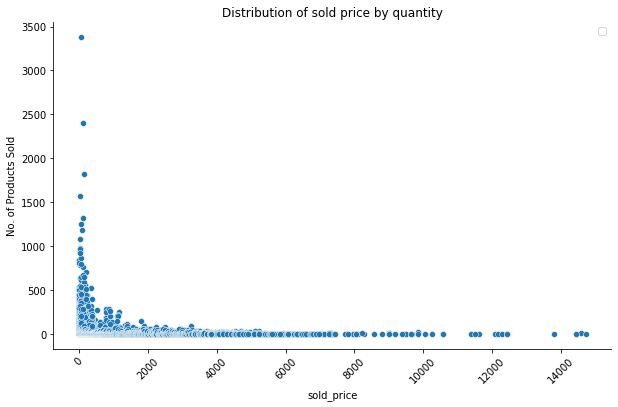

In [58]:
# show sold_price distribution to identify outliers

soldprice_dis = (
orderlines_prep
    .groupby(['yr_mnt','sold_price'])
    .agg({'qty':'sum'})
    .reset_index()
)
soldprice_dis.head()

plt.subplots(figsize=(10, 6))

ax = sns.scatterplot(data=soldprice_dis, y='qty', x='sold_price', legend=True)
vals = ax.get_yticks()

plt.legend(facecolor='white')
plt.title('Distribution of sold price by quantity')
plt.ylabel('No. of Products Sold')
plt.xlabel('sold_price')
plt.xticks(rotation = 45)
sns.despine()
plt.show()

In [59]:
from pyparsing.helpers import one_of
''' single product removed as erroneous entry, NEA0009	Netatmo home thermostat for iPhone and iPad 
has stock price of 179.00 euros but sold_price in orderlines is 160,000 euros. This row has been removed from data.
'''
outli = (
  orderlines_prep.query('sold_price > 20000')
)

'''orderlines_prep.drop(
    orderlines_prep[orderlines_prep['sold_price'] >= 20000]
    .index, inplace = True
    )'''
outli.head()

,index,order_id,sku,stock_price,sold_price,qty,total_price,date,category,price_range,year,month,yr_mnt,discount,discount_percent


In [60]:
# identifying the top five selling brands
'''
orderlines_prep['short_sku'] = orderlines_prep['sku'].str[:3]

cat_sku = (
    orderlines_prep
    .groupby('short_sku')
    .agg({'qty':'sum'})
    .sort_values('qty', ascending=False)
    .head(10)
)

cat_sku.head(10)
'''
#sskuc = orderlines_prep['short_sku'].nunique()

#print(sskuc)

"\norderlines_prep['short_sku'] = orderlines_prep['sku'].str[:3]\n\ncat_sku = (\n    orderlines_prep\n    .groupby('short_sku')\n    .agg({'qty':'sum'})\n    .sort_values('qty', ascending=False)\n    .head(10)\n)\n\ncat_sku.head(10)\n"

In [61]:
products_c['category'].value_counts()

desktop    3443
phone      3119
laptop     1070
misc        885
memory      706
tablet      610
sound       159
Name: category, dtype: int64

# Analysis

In [ ]:
orderlines_prep.head()

In [ ]:
from pandas.core.accessor import register_index_accessor

orders_cln = orders.copy()
orders_cln = (
    orders_cln
    .loc[(orders_cln['state'] == 'Completed')]
)
orders['order_id'] = orders['order_id'].astype(str)

#orders_cln.info()

orderlines_prep.rename(columns= {'id_order':'order_id'},inplace= True)

orderlines_prep = (
    orderlines_prep
    .merge(
        orders_cln, how= 'inner', on='order_id'
        )
)

    
orderlines_prep.head()


In [66]:
dft = (orderlines_prep.groupby(['year','month']).qty.agg(['mean', 'sum']))

print(dft)
'''
              qty
year             
2017-01-01  51687
2018-01-01  14118

            sold_price
year                  
2017-01-01       46037
2018-01-01       12659
'''

                      mean    sum
year       month                 
2017-01-01 1      1.130761   7091
           2      1.116560   2960
           3      1.129032    280
           4      1.130456   2305
           5      1.175734   2723
           6      1.170051   2305
           7      1.118834   4990
           8      1.112748   3247
           9      1.110830   3077
           10     1.118537   4435
           11     1.125594  10889
           12     1.093264   7385
2018-01-01 1      1.108541   7333
           2      1.116169   4708
           3      1.137459   2077


'\n              qty\nyear             \n2017-01-01  51687\n2018-01-01  14118\n\n            sold_price\nyear                  \n2017-01-01       46037\n2018-01-01       12659\n'

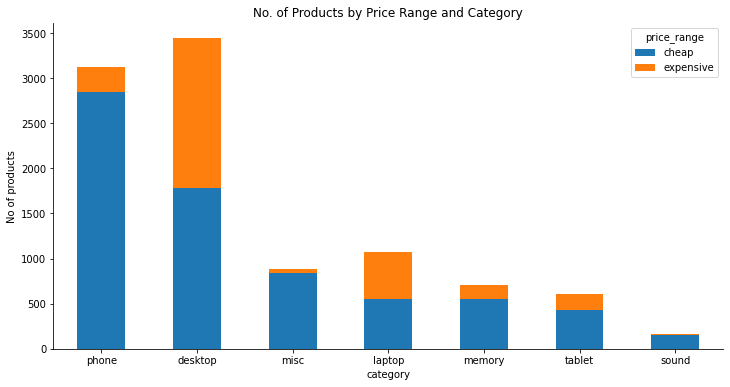

price_range category  cheap  expensive  Total No.
0            desktop   1782       1661       3443
1             laptop    554        516       1070
2             memory    548        158        706
3               misc    838         47        885
4              phone   2849        270       3119
5              sound    153          6        159
6             tablet    428        182        610


In [99]:
# How many cheap/expensive products do we have?

df =(
    products_c
     .groupby(['category', 'price_range'])
     .agg({'sku':'count'})
     .reset_index() #.groupby('price_range')['price'].sum()
)

df_trans= df.pivot(index='category', columns='price_range')['sku'].reset_index()
df_trans= df_trans[['category',	'cheap', 'expensive']]

# stacked barchart & table

df_trans.sort_values('cheap', ascending=False).plot(x='category', kind='bar', stacked=True,
        title='No. of Products by Price Range and Category', 
        figsize=(12,6))

plt.ylabel('No of products')
plt.xticks(rotation='horizontal')
sns.despine()
plt.show()

df_transop =df_trans  # op = output 
df_transop['Total No.']= df_trans['cheap'] +  df_trans['expensive']
print(df_transop)


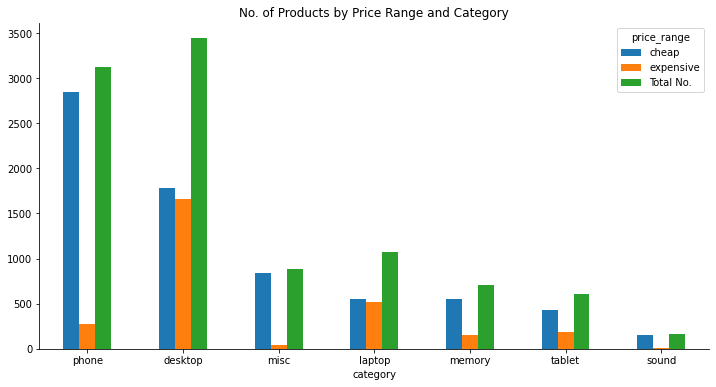

In [104]:
df_trans.sort_values(
    'cheap', ascending=False).plot(x='category', kind='bar', stacked=False,
        title='No. of Products by Price Range and Category', 
        figsize=(12,6)
        )

plt.xticks(rotation='horizontal')
sns.despine()
plt.show()

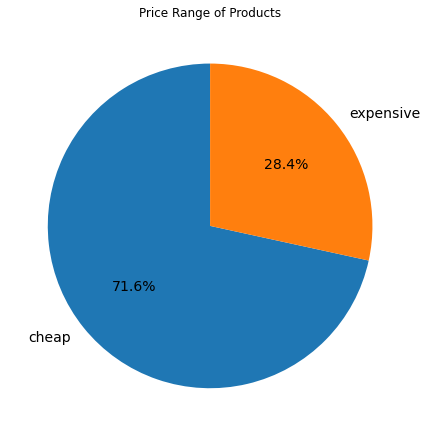

  Price Range  No. of Products
0       cheap             7152
1   expensive             2840


In [69]:
# What is the split of cheap/expensive products 
# by percentage (pie chart) & numbers (table)?

import matplotlib.pyplot as plt
df =(
    products_c
     .groupby(['price_range'])
     .agg({'sku':'count'})
     .reset_index() #.groupby('price_range')['price'].sum()
)
dfop = df.rename(columns={'price_range': 'Price Range','sku': 'No. of Products'})


# plot chart
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121, aspect='equal')
dfop.plot(kind='pie', y = 'No. of Products', ax=ax1, autopct='%1.1f%%',
 startangle=90, shadow=False, labels=df['price_range'], legend = False, fontsize=14)

plt.ylabel('')   # blank str to hide y label
plt.title('Price Range of Products')
plt.show()
print(dfop)

In [ ]:
#Revenue by cheap and expensive products & Total

revenue_gen =(
    orderlines_prep
    .groupby(['category','price_range'])['sold_price']
    .sum()
    .reset_index()
)

rg_trans = revenue_gen
rg_trans = (
    revenue_gen
    .pivot(
        index='category', columns='price_range'
        )
    ['sold_price']
    .reset_index()
)
rg_trans= rg_trans[['category',	'cheap', 'expensive']] 

rg_transop = rg_trans  # op = output 
rg_transop['Total Revenue']= rg_trans['cheap'] +  rg_trans['expensive']

print(rg_transop)

In [ ]:
#How much revenue each category is generating, category, price range & percentage?

total_revenue = rg_transop['Total Revenue'].sum()

rg_transop = rg_transop.assign(
    Sold_Price_Percent = (
        rg_transop['Total Revenue'] * 100 / total_revenue
                          )
    )
rg_transop = rg_transop.sort_values('Sold_Price_Percent', ascending=False
                 )
rg_transop['Sold_Price_Percent'] =  rg_transop['Sold_Price_Percent'].round(2)

rg_transop

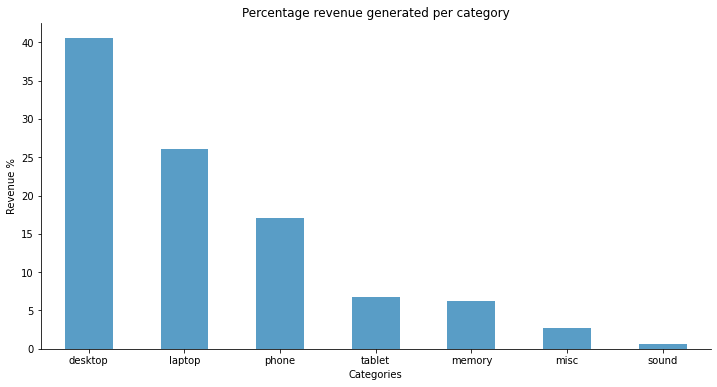

In [72]:
rg_transop.plot(
    x='category',
    y='Sold_Price_Percent',
    kind='bar',
    stacked=False,
    title='Percentage revenue generated per category', 
    figsize=(12,6),
    legend=False,
    color="#599DC6"
)

plt.xticks(rotation='horizontal')
plt.ylabel("Revenue %")
plt.xlabel("Categories")
sns.despine()

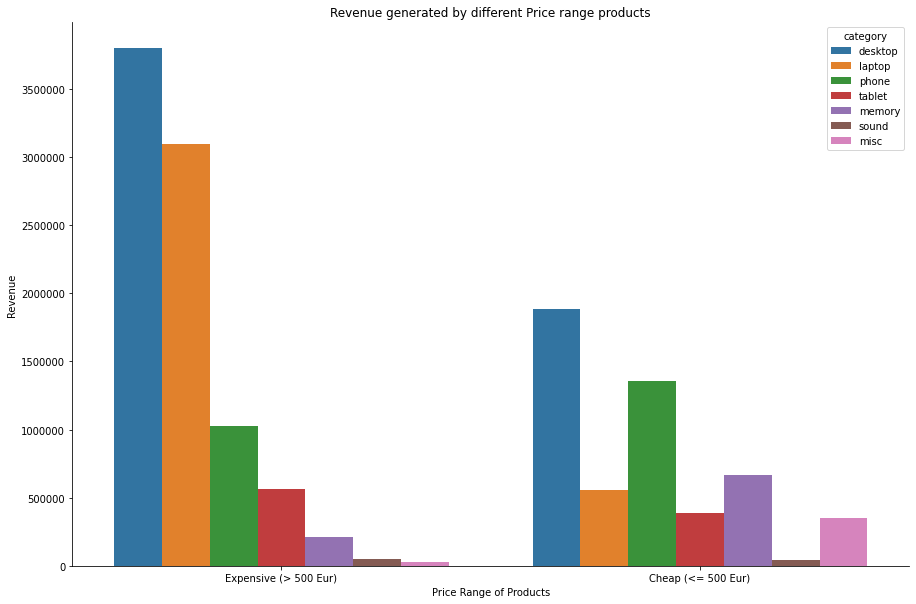

In [106]:
# Graph for Revenue generated by different price range of products
plt.subplots(figsize=(15, 10))

ax = sns.barplot(
    data=revenue_gen
    .sort_values(
        ['price_range', 'sold_price'], ascending=[False, False]
        ),
         x='price_range', y='sold_price', hue = 'category'
)

#plt.ylim(100, 15500000)
plt.xlabel('Price Range of Products')
plt.ylabel('Revenue')
plt.title('Revenue generated by different Price range products')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(['Expensive (> 500 Eur)', 'Cheap (<= 500 Eur)'])

sns.despine()
plt.show()

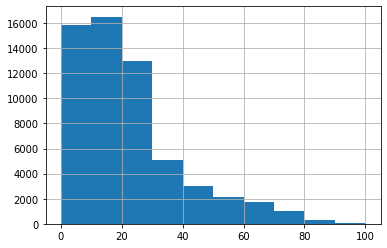

In [74]:
#How big are the discounts by category?

orderlines_prep.discount_percent.hist()

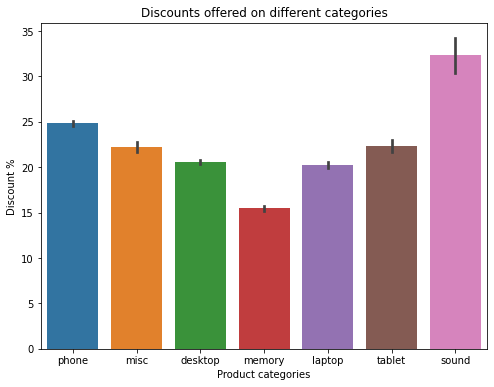

In [75]:
# Graph showing how big are the discounts by category?

plt.subplots(figsize=(8,6))

sns.barplot(data=orderlines_prep, x='category', y='discount_percent')

plt.xlabel('Product categories')
plt.ylabel('Discount %')
plt.title('Discounts offered on different categories')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [76]:
# How many products are being discounted?

do = orderlines_prep.loc[orderlines_prep['discount_percent'] > 0].sku.nunique() # 5607
#orderlines_prep.loc[orderlines_prep['discount_percent'] > 0].sold_price.sum() # 13691125.36
#orderlines_prep.loc[orderlines_prep['discount_percent'] > 0].stock_price.sum() # 16017608.650000002

print(do, 'products are being discounted')

5607 products are being discounted


Text(0, 0.5, 'Product price & discount evolution')

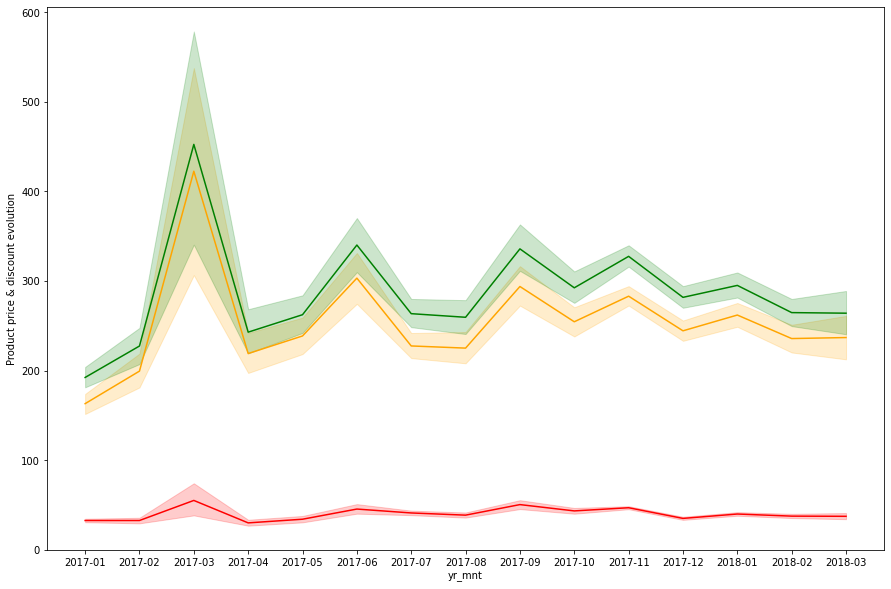

In [77]:
# How big are the offered discounts as a percentage of the product prices?

plt.subplots(figsize=(15, 10))
df = orderlines_prep

ax = sns.lineplot (data = df.sort_values(['yr_mnt'], ascending=True).query('discount > 0'), x='yr_mnt', y='sold_price', color='orange')
ax = sns.lineplot (data = df, x='yr_mnt', y='stock_price', color='green')
ax = sns.lineplot (data = df, x='yr_mnt', y='discount', color='red')
#ax = sns.lineplot (data = df.query('discount == 0'), x='year_month', y='sold_price', color='blue')

plt.ylabel('Product price & discount evolution')

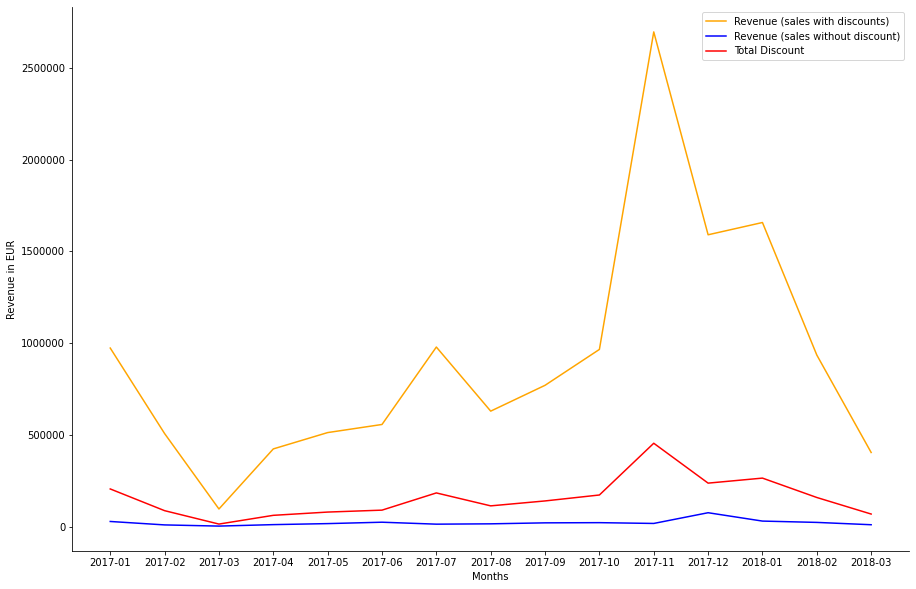

In [78]:
#How seasonality and special dates (Christmas, Black Friday) affect sales?

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

plt.subplots(figsize=(15, 10))
df_with_discounts = orderlines_prep.query('discount > 0')
df_without_discounts = orderlines_prep.query('discount <= 0')

df = df_with_discounts.groupby('yr_mnt').agg({'sold_price':'sum'})
df2 = df_with_discounts.groupby('yr_mnt').agg({'stock_price':'sum'})
df3 = df_with_discounts.groupby('yr_mnt').agg({'discount':'sum'})


df_nd = df_without_discounts.groupby('yr_mnt').agg({'sold_price':'sum'})

ax = sns.lineplot(data = df, x='yr_mnt', y='sold_price', color='orange')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax = sns.lineplot(data = df_nd, x='yr_mnt', y='sold_price', color='blue')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax = sns.lineplot(data = df2, x='yr_mnt', y='stock_price', color='green')
ax = sns.lineplot(data = df3, x='yr_mnt', y='discount', color='red')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

sns.despine()

# plt.ylim(0, 1000)

plt.ylabel('Revenue in EUR')
plt.xlabel('Months')
plt.legend(['Revenue (sales with discounts)', 'Revenue (sales without discount)', 'Total Discount'])



Text(0.5, 1.0, 'Number of sales (with discounts) per category')

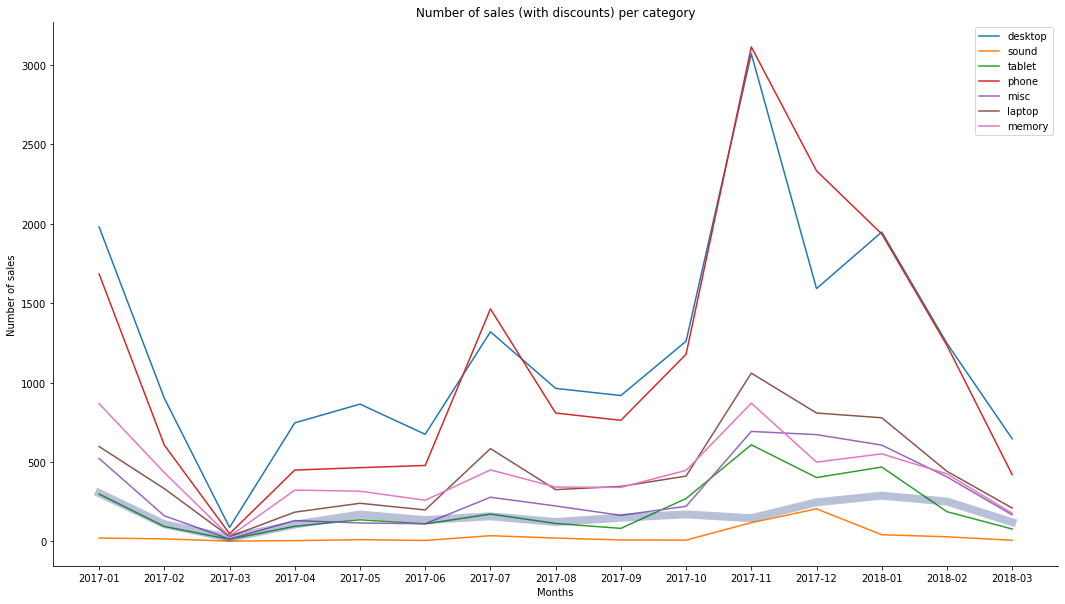

In [107]:
# Revenue per category and month

plt.subplots(figsize=(18, 10))
df = (orderlines_prep
      .query('discount > 0')
      .groupby(
          ['category', 'yr_mnt']
          )['sold_price']
      .count()
      .reset_index()
      .sort_values('yr_mnt', ascending=True
                   )
      )

df_nd_count = df_without_discounts.groupby('yr_mnt').agg({'sold_price':'count'})

ax = sns.lineplot(
    data = df, x='yr_mnt', y='sold_price', hue='category'
    )
ax = sns.lineplot(
    data = df_nd_count, x='yr_mnt', y='sold_price', linewidth=8, color=(0.1, 0.2, 0.5, 0.3)
    )
ax.yaxis.set_major_formatter(
    FormatStrFormatter('%.0f')
    )

sns.despine()

# plt.ylim(0, 1000)

plt.ylabel('Number of sales')
plt.xlabel('Months')
plt.title("Number of sales (with discounts) per category")

Text(0.5, 0, 'Months')

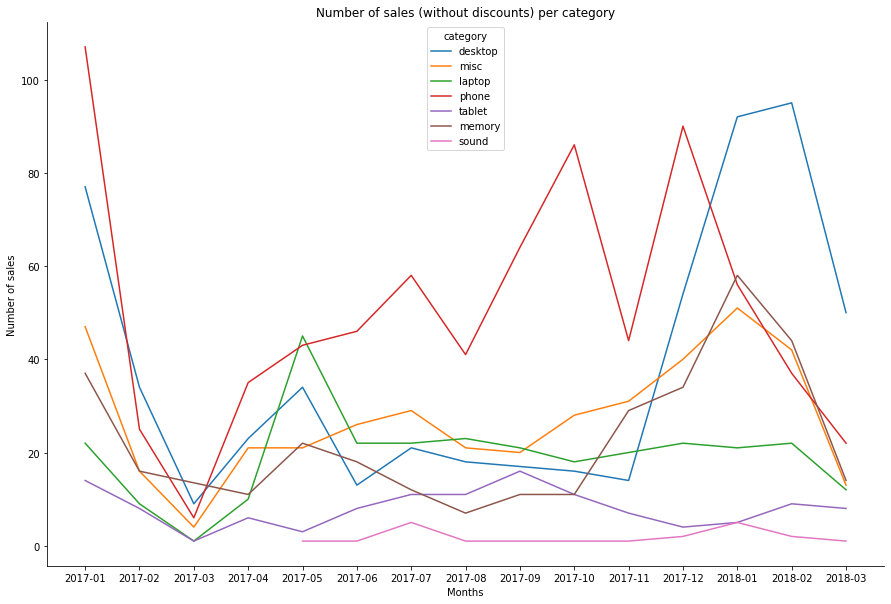

In [80]:
# Revenue per category and month

plt.subplots(figsize=(15, 10))
df = (orderlines_prep
      .query('discount == 0')
      .groupby(
          ['category', 'yr_mnt']
          )['sold_price']
      .count()
      .reset_index()
      .sort_values('yr_mnt', ascending=True)
)
df 

ax = sns.lineplot(data = df, x='yr_mnt', y='sold_price', hue='category')
sns.despine()

plt.title("Number of sales (without discounts) per category")
plt.ylabel('Number of sales')
plt.xlabel('Months')

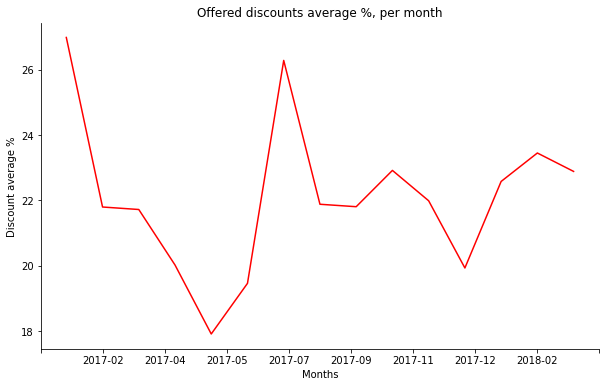

In [88]:
# Average discounts % of all products per month
import matplotlib.ticker as ticker

plt.subplots(figsize=(10,6))
sns.despine()
plt.title("Offered discounts average %, per month")
df4 = df_with_discounts.groupby('yr_mnt').agg({'discount_percent':'mean'})
ax = sns.lineplot(data = df4, x='yr_mnt', y='discount_percent', color='red')
plt.ylabel('Discount average %')
plt.xlabel('Months')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))


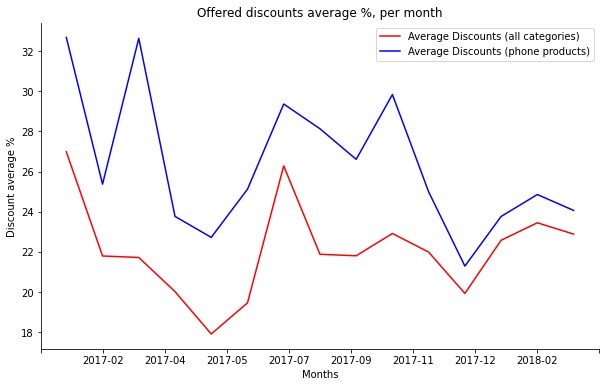

In [90]:
plt.subplots(figsize=(10,6))
sns.despine()
plt.title("Offered discounts average %, per month")
df4 = df_with_discounts.groupby('yr_mnt').agg({'discount_percent':'mean'})
df5 = df_with_discounts.groupby(['yr_mnt', 'category']).agg({'discount_percent':'mean'}).reset_index()
ax = sns.lineplot(data = df4, x='yr_mnt', y='discount_percent', color='red')
ax = sns.lineplot(data = df5.loc[df5['category'] == 'phone'], x='yr_mnt', y='discount_percent', color='blue')
plt.ylabel('Discount average %')
plt.xlabel('Months')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))

plt.legend(['Average Discounts (all categories)', 'Average Discounts (phone products)'])

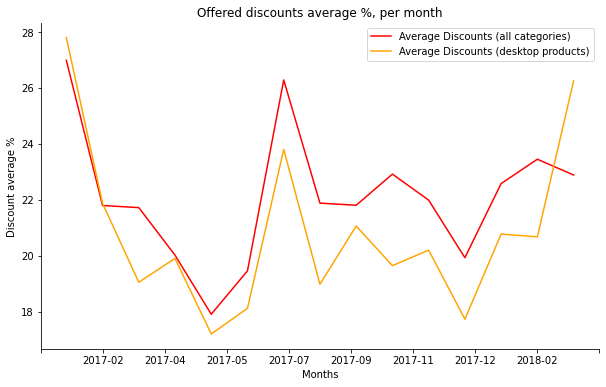

In [91]:
plt.subplots(figsize=(10,6))
sns.despine()
plt.title("Offered discounts average %, per month")
df4 = df_with_discounts.groupby('yr_mnt').agg({'discount_percent':'mean'})
df5 = df_with_discounts.groupby(['yr_mnt', 'category']).agg({'discount_percent':'mean'}).reset_index()
ax = sns.lineplot(data = df4, x='yr_mnt', y='discount_percent', color='red')
ax = sns.lineplot(data = df5.loc[df5['category'] == 'desktop'], x='yr_mnt', y='discount_percent', color='orange')
plt.ylabel('Discount average %')
plt.xlabel('Months')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.legend(['Average Discounts (all categories)', 'Average Discounts (desktop products)'])

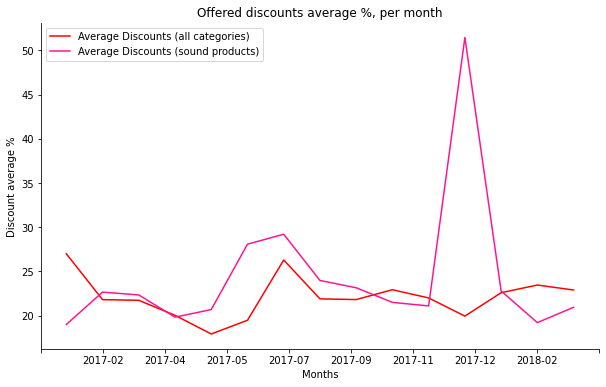

In [92]:
plt.subplots(figsize=(10,6))
sns.despine()
plt.title("Offered discounts average %, per month")
df4 = df_with_discounts.groupby('yr_mnt').agg({'discount_percent':'mean'})
df5 = df_with_discounts.groupby(['yr_mnt', 'category']).agg({'discount_percent':'mean'}).reset_index()
ax = sns.lineplot(data = df4, x='yr_mnt', y='discount_percent', color='red')
ax = sns.lineplot(data = df5.loc[df5['category'] == 'sound'], x='yr_mnt', y='discount_percent', color='deeppink')
plt.ylabel('Discount average %')
plt.xlabel('Months')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.legend(['Average Discounts (all categories)', 'Average Discounts (sound products)'])

In [94]:
df_with_discounts.loc[df_with_discounts['yr_mnt'] == '2018-03'].shape[0]
df_with_discounts.loc[df_with_discounts['yr_mnt'] == '2017-03'].shape[0]


227